# Config

In [1]:
import numpy as np
import os
import pandas as pd
import yaml

np.random.seed(3407)
np.set_printoptions(threshold=10, linewidth=1000)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # disable INFO and WARNING log
pd.set_option('display.max_colwidth', 20)

config_path = os.path.join(os.getcwd(), "config.yml")
with open(config_path, "r") as f:
    config = yaml.safe_load(f)
print(yaml.dump(config, sort_keys=False, default_flow_style=True))
dataset_root_dir = os.path.abspath(os.path.join(os.getcwd(), config["dataset"]["root_dir"]))
available_datasets = config["dataset"]["available"]
download_datasets = config["dataset"]["download"]

{dataset: {root_dir: ../dataset, available: [sift-1m, gist-1m, deep-10m, mnist-8m,
      mtg-40k, glove-twitter-1m, glove-crawl-2m, laion-1m, youtube-6m], download: [
      sift-1m, gist-1m, deep-10m, mnist-8m, mtg-40k, glove-twitter-1m, glove-crawl-2m,
      laion-1m, youtube-6m]}, proxy: {enabled: true, http: 'http://127.0.0.1:7890',
    https: 'http://127.0.0.1:7890', youtube_6m_mirror: asia}}



In [2]:
import os
from tqdm import tqdm
import glob
import numpy as np
import pandas as pd

def get_dataset_dir(dataset):
    dataset_dir = dataset_root_dir
    parts = dataset.split('-')
    for part in parts:
        dataset_dir = os.path.join(dataset_dir, part)
    return dataset_dir

def read_mnist8m(fname, dim=784, n=1000000, dtype="int"):
    with open(fname, 'r') as f:
        lines = f.readlines()
    n = min(n, len(lines))
    vectors = np.zeros((n, dim), dtype=np.int32)
    labels = np.zeros((n, 1), dtype=np.int32)
    for i, line in tqdm(enumerate(lines[:n]), total=n, dynamic_ncols=True):
        line = line.strip().split()
        labels[i, 0] = int(line[0])
        for elem in line[1:]:
            index, value = elem.split(':')
            if dtype == "int":
                vectors[i, int(index) - 1] = int(value)  # fill dense feature vector
            else:
                vectors[i, int(index) - 1] = float(value)
    return vectors, labels

def read_parquet_files(dir_path):
    parquet_files = glob.glob(os.path.join(dir_path, "*.parquet"))
    parquet_files.sort()
    df_list = [pd.read_parquet(parquet_file, engine='pyarrow') for parquet_file in tqdm(parquet_files, ncols=len(parquet_files), dynamic_ncols=True)]
    df = pd.concat(df_list, ignore_index=True)
    return df

import psutil

def show_memory():
    memory = psutil.virtual_memory()
    total_memory = memory.total
    available_memory = memory.available
    print(f"Total Memory: {total_memory / (1024 ** 3):.2f} GB")
    print(f"Available Memory: {available_memory / (1024 ** 3):.2f} GB")

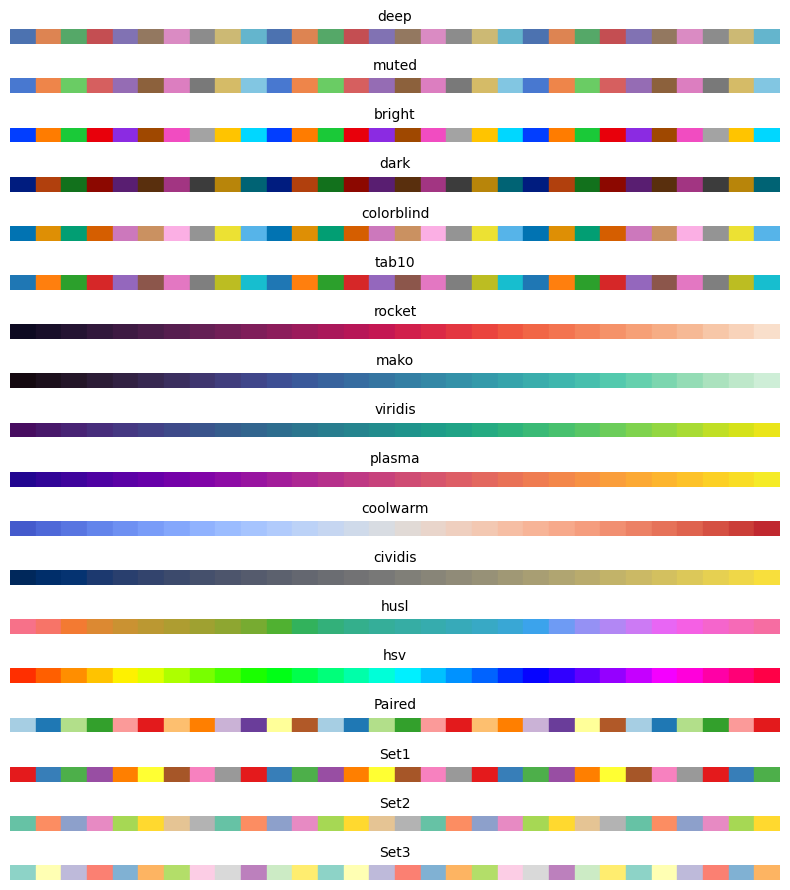

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define all color palettes to be displayed
palettes = [
    "deep", "muted", "bright", "dark", "colorblind", "tab10",  # discrete palettes
    "rocket", "mako", "viridis", "plasma", "coolwarm", "cividis",  # continuous palettes
    "husl", "hsv",  # circular palettes
    "Paired", "Set1", "Set2", "Set3",  # categorical palettes
]

# Create subplots, one row for each palette
fig, axes = plt.subplots(len(palettes), 1, figsize=(8, 0.5 * len(palettes)))

# Loop through each palette and plot its colors
for ax, palette_name in zip(axes, palettes):
    # Get the color palette
    colors = sns.color_palette(palette_name, n_colors=30)
    
    # Draw a rectangle for each color
    for i, color in enumerate(colors):
        ax.add_patch(plt.Rectangle((i, 0), 1, 1, color=color))  # draw color block
    
    ax.set_xlim(0, len(colors)) 
    ax.set_ylim(0, 1)           
    ax.axis("off")              
    ax.set_title(palette_name, fontsize=10)

plt.tight_layout()
plt.show()

In [4]:
import matplotlib.pyplot as plt
import umap
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
import ot
from scipy.spatial.distance import cdist
from mahalanobis import Mahalanobis
import faiss

def sample_vectors(vectors: np.array, sample_size: int):
    np.random.seed(3407)
    if sample_size < vectors.shape[0]:
        indices = np.random.choice(vectors.shape[0], sample_size, replace=False)
        return vectors[indices]
    else:
        return vectors

def sample_vectors_labels(vectors: np.array, labels: np.array, sample_size: int):
    np.random.seed(3407)
    if sample_size < vectors.shape[0]:
        # Calculate proportion of each label
        unique_labels, counts = np.unique(labels, return_counts=True)
        proportions = counts / len(labels)

        # Determine number of samples per label based on proportion
        samples_per_label = (proportions * sample_size).astype(int)

        sampled_indices = []
        for label, num_samples in zip(unique_labels, samples_per_label):
            label_indices = np.where(labels == label)[0]
            sampled_indices.extend(np.random.choice(label_indices, num_samples, replace=False))

        sampled_indices = np.array(sampled_indices)
        return vectors[sampled_indices], labels[sampled_indices]
    else:
        return vectors, labels

def umap_visualize_bl(vectors_base: np.array, labels: np.array, sample_size: int = 10000, xlim=None, xticks=None, ylim=None, yticks=None):
    # If labels are not numeric, encode them with LabelEncoder
    labels = labels.flatten()
    if not np.issubdtype(np.array(labels).dtype, np.number):
        label_encoder = LabelEncoder()
        labels = label_encoder.fit_transform(np.ravel(labels))  # encode labels
    else:
        label_encoder = None

    # Randomly sample data and labels
    vectors_sample, labels_sample = sample_vectors_labels(vectors_base, labels, sample_size)

    # Apply UMAP to reduce dimensionality to 2D
    umap_model = umap.UMAP(n_components=2, random_state=3407)
    vectors_2d = umap_model.fit_transform(vectors_sample)

    # Plot the 2D UMAP result using scatter
    sns.set_style('white')
    plt.figure(figsize=(6, 5))
    sns.scatterplot(
        x=vectors_2d[:, 0],
        y=vectors_2d[:, 1],
        hue=labels_sample,       # color by labels
        palette="tab10",         # use tab10 palette
        s=5,                     # point size
        alpha=0.7,               # point transparency
    )
    ax = plt.gca()
    handles, legend_labels = ax.get_legend_handles_labels()
    label_counts = {label: np.sum(labels_sample == label) for label in np.unique(labels_sample)}
    if label_encoder:
        original_to_encoded = {original: encoded for encoded, original in enumerate(label_encoder.classes_)}
        legend_labels = label_encoder.inverse_transform([int(label) for label in legend_labels])
        legend_labels_with_counts = [f"{label} ({label_counts[original_to_encoded[label]]:,})" for label in legend_labels]
    else:
        legend_labels_with_counts = [f"{label} ({label_counts[int(label)]:,})" for label in legend_labels]
    new_handles = [
        plt.Line2D([], [], marker='o', color=handle.get_color(), markersize=5, linestyle='')  # use color from handle
        for handle in handles
    ]
    ax.legend(new_handles, legend_labels_with_counts, loc="upper left", bbox_to_anchor=(1.01, 1), fontsize="small", handlelength=1, handletextpad=0.5)
    if xlim is not None and xticks is not None:
        plt.xlim(xlim[0], xlim[1])
        plt.xticks(ticks=xticks)
    if ylim is not None and yticks is not None:
        plt.ylim(ylim[0], ylim[1])
        plt.yticks(ticks=yticks)
    plt.xlabel('UMAP 1')
    plt.ylabel('UMAP 2')
    plt.show()

def sample_vectors_vectors(vectors_1: np.array, vectors_2: np.array, sample_size_1: int, sample_size_2: int, k: int):
    if np.array_equal(vectors_1, vectors_2):
        vectors = vectors_1
        if vectors_1.shape[0] < sample_size_1 + sample_size_2:
            ratio_1 = sample_size_1 / (sample_size_1 + sample_size_2)
            ratio_2 = sample_size_2 / (sample_size_1 + sample_size_2)
            sample_size_1 = int(vectors_1.shape[0] * ratio_1)
            sample_size_2 = int(vectors_1.shape[0] * ratio_2)
        np.random.seed(3407)
        indices_2 = np.random.choice(vectors.shape[0], sample_size_2, replace=False)
        vectors_2_sample = vectors[indices_2]
        remaining_indices = np.setdiff1d(np.arange(vectors.shape[0]), indices_2)
        vectors_remaining = vectors[remaining_indices]
        if k > 0:
            index = faiss.IndexFlatL2(vectors_remaining.shape[1])
            index.add(vectors_remaining)
            _, location = index.search(vectors_2_sample, k)
            unique_locations = np.unique(location)
            vectors_remaining_local = vectors_remaining[unique_locations]
            vectors_1_sample = sample_vectors(vectors_remaining_local, sample_size_1)
        else:
            vectors_1_sample = sample_vectors(vectors_remaining, sample_size_1)
        sample_size_1 = len(vectors_1_sample)
    else:
        vectors_2_sample = sample_vectors(vectors_2, sample_size_2)
        sample_size_2 = len(vectors_2_sample)
        if k > 0:
            index = faiss.IndexFlatL2(vectors_1.shape[1])
            index.add(vectors_1)
            _, location = index.search(vectors_2_sample, k)
            unique_locations = np.unique(location)
            vectors_1_local = vectors_1[unique_locations]
            vectors_1_sample = sample_vectors(vectors_1_local, sample_size_1)   
        else:
            vectors_1_sample = sample_vectors(vectors_1, sample_size_1)
        sample_size_1 = len(vectors_1_sample)
    
    return vectors_1_sample, vectors_2_sample, sample_size_1, sample_size_2

def wasserstein_distance(vectors_1: np.array, vectors_2: np.array, sample_size_1: int = 1000, sample_size_2: int = 1000, k: int = 0, metric: str = "euclidean"): 
    # Randomly sample vectors
    vectors_1_sample, vectors_2_sample, sample_size_1, sample_size_2 = sample_vectors_vectors(vectors_1, vectors_2, sample_size_1, sample_size_2, k)

    # Compute the distance matrix using scipy's cdist (e.g., Euclidean)
    # M = np.linalg.norm(vectors_1_sample[:, None] - vectors_2_sample[None, :], axis=-1)
    # cdist handles batch computation efficiently without high memory usage
    M = cdist(vectors_1_sample, vectors_2_sample, metric=metric)

    # Compute the Wasserstein distance
    # Assume uniform weights for each sample
    a = np.ones(sample_size_1) / sample_size_1
    b = np.ones(sample_size_2) / sample_size_2

    # Compute Wasserstein distance using Optimal Transport (OT) algorithm
    wasserstein_dist = ot.emd2(a, b, M, numItermax=max(sample_size_1, sample_size_2)*10000, numThreads="max")

    return wasserstein_dist

def wasserstein_distances_heatmap(vectors: np.array, labels: np.array, sample_size_1: int = 1000, sample_size_2: int = 1000, k: int = 0, metric: str = "euclidean", precision=".2f"):
    labels = labels.flatten()
    unique_labels = np.unique(labels)
    n_unique_labels = len(unique_labels)
    vectors_labels = []
    for unique_label in unique_labels:
        vectors_labels.append(vectors[labels == unique_label])
    
    wasserstein_matrix = np.zeros((n_unique_labels, n_unique_labels))
    progress = tqdm(total=(n_unique_labels * (n_unique_labels + 1)) // 2, dynamic_ncols=True)
    for i in range(n_unique_labels):
        for j in range(i, n_unique_labels):
            wasserstein_ij = wasserstein_distance(vectors_labels[i], vectors_labels[j], sample_size_1, sample_size_2, k, metric)
            wasserstein_matrix[i, j] = wasserstein_ij
            wasserstein_matrix[j, i] = wasserstein_ij
            progress.set_description(f"Processing: ({i}, {j})")
            progress.update(1)
    progress.close()

    plt.figure(figsize=(min(6,n_unique_labels), min(5,0.8*n_unique_labels)))
    sns.heatmap(wasserstein_matrix, annot=True, fmt=precision, cmap='coolwarm', annot_kws={"size": "small"}, xticklabels=unique_labels, yticklabels=unique_labels)
    plt.title('Wasserstein Distances', fontsize="medium")
    plt.xlabel('Label x', fontsize="medium")
    plt.ylabel('Label y', fontsize="medium")
    plt.show()

def mahalanobis_distances(vectors_1: np.array, vectors_2: np.array, sample_size_1: int = 100000, sample_size_2: int = 100000, k: int = 0):
    # Randomly sample vectors
    vectors_1_sample, vectors_2_sample, sample_size_1, sample_size_2 = sample_vectors_vectors(vectors_1, vectors_2, sample_size_1, sample_size_2, k)

    mahND = Mahalanobis(vectors_1_sample, sample_size_1)
    mahalanobis_dists = mahND.calc_distances(vectors_2_sample)
    
    return mahalanobis_dists

def mahalanobis_distances_histograms(vectors: np.array, labels: np.array, sample_size_1: int = 100000, sample_size_2: int = 100000, k: int = 0, num_bins: int = 50, x_lim: float = 0, x_ticks=None, y_ticks=None, wspace: float = 0.5, hspace: float = 0.5, bbox_to_anchor=(0.94,1.01), figsize=None, show_word=True):
    labels = labels.flatten()
    unique_labels = np.unique(labels)
    n_unique_labels = len(unique_labels)
    vectors_labels = []

    for unique_label in unique_labels:
        vectors_labels.append(vectors[labels == unique_label])

    nrows = n_unique_labels
    ncols = n_unique_labels

    # Dynamically determine figure size
    if figsize is None:
        figsize = (max(1.6*6, 1.6*ncols), max(1.2*6, 1.2*nrows))  # Adjust size based on label count
    else:
        figsize = figsize
    plt.figure(figsize=figsize)

    progress = tqdm(total=nrows*ncols, dynamic_ncols=True)

    # Global legend handles
    legend_items = []

    for i in range(nrows):
        for j in range(ncols):
            vectors_1 = vectors_labels[i]
            vectors_2 = vectors_labels[j]

            # Compute Mahalanobis distances
            mahalanobis_distances_11 = mahalanobis_distances(vectors_1, vectors_1, sample_size_1, sample_size_2, k)
            mahalanobis_distances_12 = mahalanobis_distances(vectors_1, vectors_2, sample_size_1, sample_size_2, k)

            mahalanobis_distances_11_flat = mahalanobis_distances_11.flatten()
            mahalanobis_distances_12_flat = mahalanobis_distances_12.flatten()
            len_1 = len(mahalanobis_distances_11_flat)
            len_2 = len(mahalanobis_distances_12_flat)

            if x_lim > 0 and len_1 > 0 and len_2 > 0:
                mahalanobis_distances_11_flat = mahalanobis_distances_11_flat[mahalanobis_distances_11_flat <= x_lim]
                mahalanobis_distances_12_flat = mahalanobis_distances_12_flat[mahalanobis_distances_12_flat <= x_lim]
                bins = np.linspace(0, x_lim, num_bins)
            else:
                bins = np.linspace(0, max(mahalanobis_distances_11_flat.max(), mahalanobis_distances_12_flat.max()), num_bins)

            sns.set_style("whitegrid")
            plt.subplot(nrows, ncols, i * ncols + j + 1)

            # Draw histograms and smoothed lines
            counts_11, edges_11, patches_11 = plt.hist(mahalanobis_distances_11_flat, bins=bins, label='Base to Base', color=sns.color_palette("tab10")[0], alpha=0.5)
            counts_12, edges_12, patches_12 = plt.hist(mahalanobis_distances_12_flat, bins=bins, label='Query to Base', color=sns.color_palette("tab10")[1], alpha=0.5)
            centers_11 = 0.5 * (edges_11[:-1] + edges_11[1:])
            centers_12 = 0.5 * (edges_12[:-1] + edges_12[1:])
            plt.plot(centers_11, counts_11, color=sns.color_palette("tab10")[0], linewidth=1)
            plt.plot(centers_12, counts_12, color=sns.color_palette("tab10")[1], linewidth=1)

            # Title for each subplot
            plt.title(f"{unique_labels[i]} - {unique_labels[j]}", fontsize="x-small")

            # Font size for axis ticks
            plt.tick_params(axis='x', labelsize='xx-small')
            plt.tick_params(axis='y', labelsize='xx-small')
            
            # Set custom ticks if provided
            if x_ticks is not None:
                plt.xticks(x_ticks)
            if y_ticks is not None:
                plt.yticks(y_ticks)

            # Remove individual subplot labels
            plt.xlabel("")
            plt.ylabel("")

            # Store legend items from the first subplot
            if i == 0 and j == 0:
                legend_items.append(patches_11[0])
                legend_items.append(patches_12[0])

            progress.set_description(f"Processing: ({i}, {j})")
            progress.update(1)

    progress.close()

    if show_word:
        # Add global title
        if x_lim > 0:
            plt.suptitle(f'Mahalanobis Distances Histograms (x < {x_lim:.2f})', y=1)
        else:
            plt.suptitle('Mahalanobis Distances Histograms', y=1)

        # Add global axis labels
        plt.gcf().text(0.5, 0, "Mahalanobis Distance", ha="center")
        plt.gcf().text(0, 0.5, "Frequency", va="center", rotation="vertical")

    # Add global legend
    if legend_items:
        plt.figlegend(
            legend_items,
            ['Base to Base', 'Query to Base'],
            loc="upper right",  # top-right corner
            bbox_to_anchor=bbox_to_anchor,  # align with title
            ncol=2,  # two columns
            fontsize="x-small",
            borderaxespad=0.2
        )

    # Adjust spacing between subplots
    plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05, wspace=wspace, hspace=hspace)  # leave space for global title
    plt.show()

def knn_distances(vectors_1: np.array, vectors_2: np.array, sample_size_1: int = 100000, sample_size_2: int = 100000, k: int = 1):
    # Randomly sample vectors
    vectors_1_sample, vectors_2_sample, sample_size_1, sample_size_2 = sample_vectors_vectors(vectors_1, vectors_2, sample_size_1, sample_size_2, k=0)

    index = faiss.IndexFlatL2(vectors_1_sample.shape[1])
    index.add(vectors_1_sample)
    distance, _ = index.search(vectors_2_sample, k)
    distance_mean = np.mean(distance, axis=1)

    return distance_mean

def calculate_recall(groundtruths, locations, query_size):
    recalls = []
    for i in range(query_size):
        groundtruth_set = set(groundtruths[i])
        retrieved_set = set(locations[i])
        intersection = len(retrieved_set.intersection(groundtruth_set))
        recall = intersection / len(groundtruth_set)
        recalls.append(recall)
    return np.mean(recalls)

def ivfflat_nprobe_recall(vectors_base, vectors_query, base_size=None, query_size=None, k=10, ncluster=500, nprobe_values = list(range(1, 101))):
    dim = vectors_base.shape[1]
    if base_size is not None:
        vectors_base = sample_vectors(vectors_base, base_size)
    if query_size is not None:
        vectors_query = sample_vectors(vectors_query, query_size)
    # groundtruth
    print("groundtruth")
    index_gt = faiss.IndexFlatL2(dim)
    index_gt.add(vectors_base)
    _, groundtruths = index_gt.search(vectors_query, k)
    # search
    print("build ivf")
    quantizer = faiss.IndexFlatL2(dim)
    index_ivf = faiss.IndexIVFFlat(quantizer, dim, ncluster)
    index_ivf.train(vectors_base)
    index_ivf.add(vectors_base)
    recalls = []
    for nprobe in tqdm(nprobe_values):
        index_ivf.nprobe = nprobe
        _, locations = index_ivf.search(vectors_query, k)
        recall = calculate_recall(groundtruths, locations, query_size)
        recalls.append(recall)
    return recalls

def hnswflat_efsearch_recall(vectors_base, vectors_query, base_size=None, query_size=None, k=10, m=32, efConstruction=40, efSearch_values = list(range(1, 101))):
    dim = vectors_base.shape[1]
    if base_size is not None:
        vectors_base = sample_vectors(vectors_base, base_size)
    if query_size is not None:
        vectors_query = sample_vectors(vectors_query, query_size)
    # groundtruth
    print("groundtruth")
    index_gt = faiss.IndexFlatL2(dim)
    index_gt.add(vectors_base)
    _, groundtruths = index_gt.search(vectors_query, k)
    # search
    print("build hnsw")
    index_hnsw = faiss.IndexHNSWFlat(dim, m)
    index_hnsw.hnsw.efConstruction = efConstruction
    index_hnsw.add(vectors_base)
    index_hnsw.hnsw.search_bounded_queue = True
    recalls = []
    for efSearch in tqdm(efSearch_values):
        index_hnsw.hnsw.efSearch = efSearch
        _, locations = index_hnsw.search(vectors_query, k)
        recall = calculate_recall(groundtruths, locations, query_size)
        recalls.append(recall)
    return recalls

def write_recalls(txt_file, lists):
    with open(txt_file, "w") as file:
        for name, recall_list in lists.items():
            line = f"{name} {len(recall_list)} " + " ".join(map(str, recall_list)) + "\n"
            file.write(line)

def read_recalls(txt_file):
    with open(txt_file, "r") as file:
        for line in file:
            parts = line.strip().split()
            list_name = parts[0]
            list_data = list(map(float, parts[2:]))
            globals()[list_name] = list_data

os.makedirs("dataset_analysis", exist_ok=True)

# mnist-8m (479) 

In [5]:
vectors_base, labels = read_mnist8m(os.path.join(get_dataset_dir("mnist-8m"), "mnist8m"))

100%|██████████| 1000000/1000000 [01:42<00:00, 9733.73it/s]


/home/lyj/download/miniconda3/envs/fanns/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/lyj/download/miniconda3/envs/fanns/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


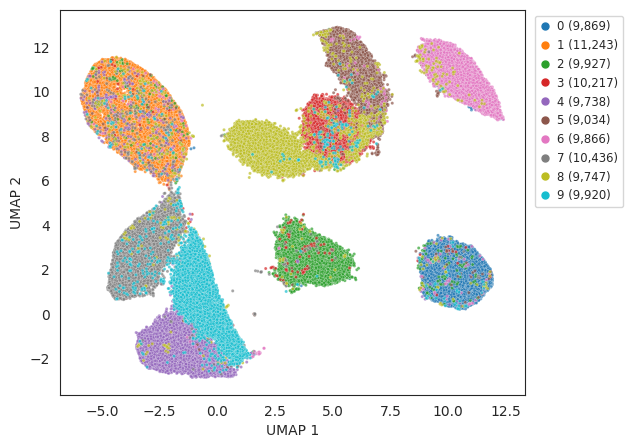

In [6]:
umap_visualize_bl(vectors_base, labels, sample_size=100000)

In [7]:
vectors_base_4 = vectors_base[np.where(labels == 4)[0]]
vectors_base_7 = vectors_base[np.where(labels == 7)[0]]
vectors_base_9 = vectors_base[np.where(labels == 9)[0]]
vectors_base_479 = np.vstack((vectors_base_4, vectors_base_7, vectors_base_9))
labels_479 = np.array([4] * vectors_base_4.shape[0] + [7] * vectors_base_7.shape[0] + [9] * vectors_base_9.shape[0])

In [8]:
k = 10
query_size = 1000

# ivf
ncluster = 2048
nprobe_values = list(range(1, 101))

# hnsw
m = 32
efConstruction = 40
efSearch_values = list(range(1,101))

In [9]:
recalls_ivf_4_4 = ivfflat_nprobe_recall(vectors_base_4, vectors_base_4, query_size=query_size, k=k, ncluster=ncluster, nprobe_values=nprobe_values)
recalls_ivf_4_7 = ivfflat_nprobe_recall(vectors_base_4, vectors_base_7, query_size=query_size, k=k, ncluster=ncluster, nprobe_values=nprobe_values)
recalls_ivf_4_9 = ivfflat_nprobe_recall(vectors_base_4, vectors_base_9, query_size=query_size, k=k, ncluster=ncluster, nprobe_values=nprobe_values)
recalls_ivf_7_4 = ivfflat_nprobe_recall(vectors_base_7, vectors_base_4, query_size=query_size, k=k, ncluster=ncluster, nprobe_values=nprobe_values)
recalls_ivf_7_7 = ivfflat_nprobe_recall(vectors_base_7, vectors_base_7, query_size=query_size, k=k, ncluster=ncluster, nprobe_values=nprobe_values)
recalls_ivf_7_9 = ivfflat_nprobe_recall(vectors_base_7, vectors_base_9, query_size=query_size, k=k, ncluster=ncluster, nprobe_values=nprobe_values)
recalls_ivf_9_4 = ivfflat_nprobe_recall(vectors_base_9, vectors_base_4, query_size=query_size, k=k, ncluster=ncluster, nprobe_values=nprobe_values)
recalls_ivf_9_7 = ivfflat_nprobe_recall(vectors_base_9, vectors_base_7, query_size=query_size, k=k, ncluster=ncluster, nprobe_values=nprobe_values)
recalls_ivf_9_9 = ivfflat_nprobe_recall(vectors_base_9, vectors_base_9, query_size=query_size, k=k, ncluster=ncluster, nprobe_values=nprobe_values)

groundtruth
build ivf


100%|██████████| 100/100 [00:16<00:00,  6.17it/s]


groundtruth
build ivf


100%|██████████| 100/100 [00:14<00:00,  7.11it/s]


groundtruth
build ivf


100%|██████████| 100/100 [00:15<00:00,  6.38it/s]


groundtruth
build ivf


100%|██████████| 100/100 [00:13<00:00,  7.21it/s]


groundtruth
build ivf


100%|██████████| 100/100 [00:17<00:00,  5.72it/s]


groundtruth
build ivf


100%|██████████| 100/100 [00:14<00:00,  6.73it/s]


groundtruth
build ivf


100%|██████████| 100/100 [00:14<00:00,  6.82it/s]


groundtruth
build ivf


100%|██████████| 100/100 [00:13<00:00,  7.39it/s]


groundtruth
build ivf


100%|██████████| 100/100 [00:15<00:00,  6.65it/s]


In [10]:
lists = {
    "recalls_ivf_4_4": recalls_ivf_4_4,
    "recalls_ivf_4_7": recalls_ivf_4_7,
    "recalls_ivf_4_9": recalls_ivf_4_9,
    "recalls_ivf_7_4": recalls_ivf_7_4,
    "recalls_ivf_7_7": recalls_ivf_7_7,
    "recalls_ivf_7_9": recalls_ivf_7_9,
    "recalls_ivf_9_4": recalls_ivf_9_4,
    "recalls_ivf_9_7": recalls_ivf_9_7,
    "recalls_ivf_9_9": recalls_ivf_9_9
}

write_recalls("dataset_analysis/mnist_ivf.txt", lists)

In [11]:
read_recalls("dataset_analysis/mnist_ivf.txt")

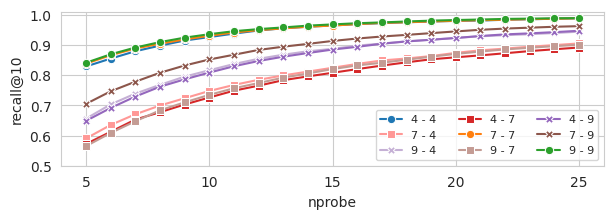

In [12]:
palette = sns.color_palette("tab20", 20)

sns.set_style("whitegrid")
plt.figure(figsize=(7, 2))

seg = [4,25]
marker_size = 6
x_ticks = [5,10,15,20,25]
y_ticks = [0.5,0.6,0.7,0.8,0.9,1.0]

sns.lineplot(x=nprobe_values[seg[0]: seg[1]], y=recalls_ivf_4_4[seg[0]: seg[1]], marker="o", markersize=marker_size, label='4 - 4', color=palette[0])
sns.lineplot(x=nprobe_values[seg[0]: seg[1]], y=recalls_ivf_7_4[seg[0]: seg[1]], marker="s", markersize=marker_size, label='7 - 4', color=palette[7])
sns.lineplot(x=nprobe_values[seg[0]: seg[1]], y=recalls_ivf_9_4[seg[0]: seg[1]], marker="X", markersize=marker_size, label='9 - 4', color=palette[9])
sns.lineplot(x=nprobe_values[seg[0]: seg[1]], y=recalls_ivf_4_7[seg[0]: seg[1]], marker="s", markersize=marker_size, label='4 - 7', color=palette[6])
sns.lineplot(x=nprobe_values[seg[0]: seg[1]], y=recalls_ivf_7_7[seg[0]: seg[1]], marker="o", markersize=marker_size, label='7 - 7', color=palette[2])
sns.lineplot(x=nprobe_values[seg[0]: seg[1]], y=recalls_ivf_9_7[seg[0]: seg[1]], marker="s", markersize=marker_size, label='9 - 7', color=palette[11])
sns.lineplot(x=nprobe_values[seg[0]: seg[1]], y=recalls_ivf_4_9[seg[0]: seg[1]], marker="X", markersize=marker_size, label='4 - 9', color=palette[8])
sns.lineplot(x=nprobe_values[seg[0]: seg[1]], y=recalls_ivf_7_9[seg[0]: seg[1]], marker="X", markersize=marker_size, label='7 - 9', color=palette[10])
sns.lineplot(x=nprobe_values[seg[0]: seg[1]], y=recalls_ivf_9_9[seg[0]: seg[1]], marker="o", markersize=marker_size, label='9 - 9', color=palette[4])

plt.xticks(x_ticks)
plt.yticks(y_ticks)

# plt.title('Number of clusters probed by IVFFlat')
plt.xlabel('nprobe')
plt.ylabel(f"recall@{k}")

plt.legend(ncols=3, loc='lower right', fontsize=8)
plt.show()

In [13]:
recalls_hnsw_4_4 = hnswflat_efsearch_recall(vectors_base_4, vectors_base_4, query_size=query_size, k=k, m=m, efConstruction=efConstruction, efSearch_values=efSearch_values)
recalls_hnsw_4_7 = hnswflat_efsearch_recall(vectors_base_4, vectors_base_7, query_size=query_size, k=k, m=m, efConstruction=efConstruction, efSearch_values=efSearch_values)
recalls_hnsw_4_9 = hnswflat_efsearch_recall(vectors_base_4, vectors_base_9, query_size=query_size, k=k, m=m, efConstruction=efConstruction, efSearch_values=efSearch_values)
recalls_hnsw_7_4 = hnswflat_efsearch_recall(vectors_base_7, vectors_base_4, query_size=query_size, k=k, m=m, efConstruction=efConstruction, efSearch_values=efSearch_values)
recalls_hnsw_7_7 = hnswflat_efsearch_recall(vectors_base_7, vectors_base_7, query_size=query_size, k=k, m=m, efConstruction=efConstruction, efSearch_values=efSearch_values)
recalls_hnsw_7_9 = hnswflat_efsearch_recall(vectors_base_7, vectors_base_9, query_size=query_size, k=k, m=m, efConstruction=efConstruction, efSearch_values=efSearch_values)
recalls_hnsw_9_4 = hnswflat_efsearch_recall(vectors_base_9, vectors_base_4, query_size=query_size, k=k, m=m, efConstruction=efConstruction, efSearch_values=efSearch_values)
recalls_hnsw_9_7 = hnswflat_efsearch_recall(vectors_base_9, vectors_base_7, query_size=query_size, k=k, m=m, efConstruction=efConstruction, efSearch_values=efSearch_values)
recalls_hnsw_9_9 = hnswflat_efsearch_recall(vectors_base_9, vectors_base_9, query_size=query_size, k=k, m=m, efConstruction=efConstruction, efSearch_values=efSearch_values)

groundtruth
build hnsw


100%|██████████| 100/100 [00:17<00:00,  5.80it/s]


groundtruth
build hnsw


100%|██████████| 100/100 [00:18<00:00,  5.38it/s]


groundtruth
build hnsw


100%|██████████| 100/100 [00:19<00:00,  5.23it/s]


groundtruth
build hnsw


100%|██████████| 100/100 [00:19<00:00,  5.17it/s]


groundtruth
build hnsw


100%|██████████| 100/100 [00:17<00:00,  5.69it/s]


groundtruth
build hnsw


100%|██████████| 100/100 [00:17<00:00,  5.60it/s]


groundtruth
build hnsw


100%|██████████| 100/100 [00:16<00:00,  6.12it/s]


groundtruth
build hnsw


100%|██████████| 100/100 [00:16<00:00,  6.03it/s]


groundtruth
build hnsw


100%|██████████| 100/100 [00:14<00:00,  7.03it/s]


In [14]:
lists = {
    "recalls_hnsw_4_4": recalls_hnsw_4_4,
    "recalls_hnsw_4_7": recalls_hnsw_4_7,
    "recalls_hnsw_4_9": recalls_hnsw_4_9,
    "recalls_hnsw_7_4": recalls_hnsw_7_4,
    "recalls_hnsw_7_7": recalls_hnsw_7_7,
    "recalls_hnsw_7_9": recalls_hnsw_7_9,
    "recalls_hnsw_9_4": recalls_hnsw_9_4,
    "recalls_hnsw_9_7": recalls_hnsw_9_7,
    "recalls_hnsw_9_9": recalls_hnsw_9_9
}
write_recalls("dataset_analysis/mnist_hnsw.txt", lists)


In [15]:
read_recalls("dataset_analysis/mnist_hnsw.txt")

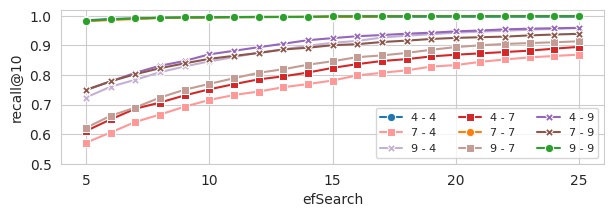

In [16]:
palette = sns.color_palette("tab20", 20)

sns.set_style("whitegrid")
plt.figure(figsize=(7, 2))

marker_size = 6
seg = [4,25]
x_ticks = [5,10,15,20,25]
y_ticks = [0.5,0.6,0.7,0.8,0.9,1.0]

sns.lineplot(x=efSearch_values[seg[0]: seg[1]], y=recalls_hnsw_4_4[seg[0]: seg[1]], marker="o", markersize=marker_size, label='4 - 4', color=palette[0])
sns.lineplot(x=efSearch_values[seg[0]: seg[1]], y=recalls_hnsw_7_4[seg[0]: seg[1]], marker="s", markersize=marker_size, label='7 - 4', color=palette[7])
sns.lineplot(x=efSearch_values[seg[0]: seg[1]], y=recalls_hnsw_9_4[seg[0]: seg[1]], marker="X", markersize=marker_size, label='9 - 4', color=palette[9])
sns.lineplot(x=efSearch_values[seg[0]: seg[1]], y=recalls_hnsw_4_7[seg[0]: seg[1]], marker="s", markersize=marker_size, label='4 - 7', color=palette[6])
sns.lineplot(x=efSearch_values[seg[0]: seg[1]], y=recalls_hnsw_7_7[seg[0]: seg[1]], marker="o", markersize=marker_size, label='7 - 7', color=palette[2])
sns.lineplot(x=efSearch_values[seg[0]: seg[1]], y=recalls_hnsw_9_7[seg[0]: seg[1]], marker="s", markersize=marker_size, label='9 - 7', color=palette[11])
sns.lineplot(x=efSearch_values[seg[0]: seg[1]], y=recalls_hnsw_4_9[seg[0]: seg[1]], marker="X", markersize=marker_size, label='4 - 9', color=palette[8])
sns.lineplot(x=efSearch_values[seg[0]: seg[1]], y=recalls_hnsw_7_9[seg[0]: seg[1]], marker="X", markersize=marker_size, label='7 - 9', color=palette[10])
sns.lineplot(x=efSearch_values[seg[0]: seg[1]], y=recalls_hnsw_9_9[seg[0]: seg[1]], marker="o", markersize=marker_size, label='9 - 9', color=palette[4])

plt.xticks(x_ticks)
plt.yticks(y_ticks)

plt.xlabel('efSearch')
plt.ylabel(f"recall@{k}")

plt.legend(ncols=3, loc='lower right', fontsize=8)
plt.show()

Processing: (2, 2): 100%|██████████| 9/9 [00:21<00:00,  2.43s/it]


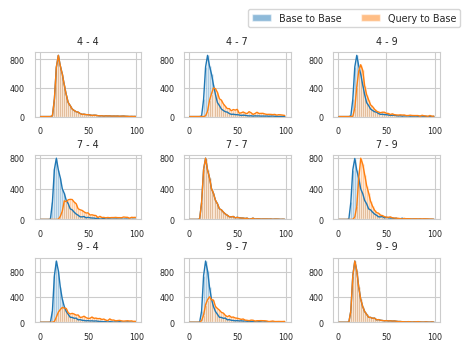

In [17]:
mahalanobis_distances_histograms(
    vectors_base_479, labels_479, 
    sample_size_1=5000, sample_size_2=5000, x_lim=100, x_ticks=[0,50,100], y_ticks=[0,400,800],
    hspace=0.6, wspace=0.4, bbox_to_anchor=(1,1.1), figsize=(4.5,3), show_word=False
)

Processing: (2, 2): 100%|██████████| 6/6 [16:33<00:00, 165.56s/it]


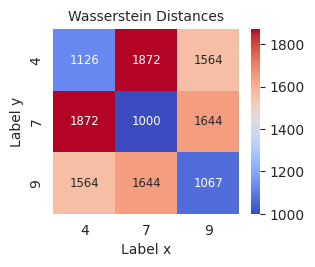

In [18]:
wasserstein_distances_heatmap(vectors_base_479, labels_479, sample_size_1=10000, sample_size_2=10000, precision=".0f")

# mtg-40k (common, rare, umcommon)

In [19]:
df = read_parquet_files(get_dataset_dir("mtg-40k"))

100%|██████████| 7/7 [00:14<00:00,  2.10s/it]


In [20]:
vectors_base = np.vstack(df["open_clip_image_embeddings"].values)
rarity = np.vstack(df["rarity"].values)

/home/lyj/download/miniconda3/envs/fanns/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/lyj/download/miniconda3/envs/fanns/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


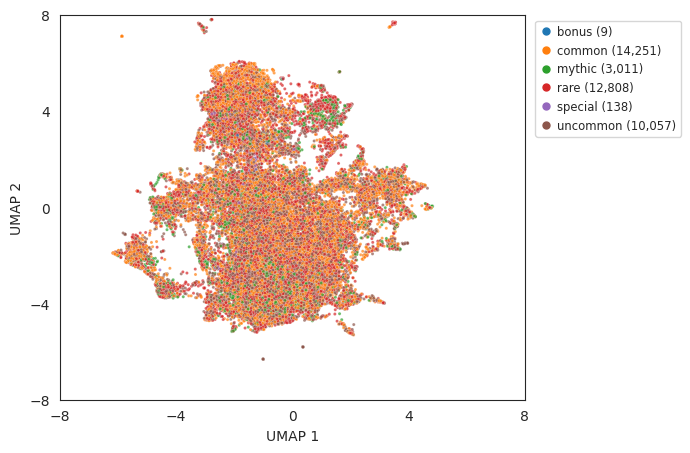

In [21]:
umap_visualize_bl(
    vectors_base, rarity, sample_size=1000000,
    xlim=[-8,8], xticks=[-8,-4,0,4,8],
    ylim=[-8,8], yticks=[-8,-4,0,4,8],
)

In [22]:
vectors_base_common = vectors_base[np.where(rarity == "common")[0]]
vectors_base_rare = vectors_base[np.where(rarity == "rare")[0]]
vectors_base_uncommon = vectors_base[np.where(rarity == "uncommon")[0]]
vectors_base_cru = np.vstack((vectors_base_common, vectors_base_rare, vectors_base_uncommon))
rarity_cru = np.array(["common"] * vectors_base_common.shape[0] + ["rare"] * vectors_base_rare.shape[0] + ["uncommon"] * vectors_base_uncommon.shape[0])

In [23]:
print(vectors_base_cru.shape)
print("First 5 base vectors:")
print(vectors_base_cru[:5])
print(50*'-')

print(rarity_cru.shape)
print("First 5 rarity:")
print(rarity_cru[:5])
print(50*'-')

(37116, 1152)
First 5 base vectors:
[[-0.00376118  0.01179656 -0.01300399 ...  0.02097553  0.00582058  0.00608341]
 [ 0.00346047 -0.00658036 -0.00275494 ...  0.01416791  0.00723666 -0.01654915]
 [-0.00093164 -0.01183124 -0.00819114 ...  0.00207677 -0.00973443 -0.01987386]
 [-0.01671699  0.00594214 -0.01216122 ...  0.03769472 -0.02277943 -0.01470586]
 [ 0.00559178 -0.00448733 -0.02801833 ...  0.02297031 -0.01765266 -0.01664608]]
--------------------------------------------------
(37116,)
First 5 rarity:
['common' 'common' 'common' 'common' 'common']
--------------------------------------------------


In [24]:
k = 10
query_size = 1000

# ivf
ncluster = 256
nprobe_values = list(range(1, 101))

# hnsw
m = 32
efConstruction = 40
efSearch_values = list(range(1,101))

In [25]:
recalls_ivf_common_common = ivfflat_nprobe_recall(vectors_base_common, vectors_base_common, query_size=query_size, k=k, ncluster=ncluster, nprobe_values=nprobe_values)
recalls_ivf_common_rare = ivfflat_nprobe_recall(vectors_base_common, vectors_base_rare, query_size=query_size, k=k, ncluster=ncluster, nprobe_values=nprobe_values)
recalls_ivf_common_uncommon = ivfflat_nprobe_recall(vectors_base_common, vectors_base_uncommon, query_size=query_size, k=k, ncluster=ncluster, nprobe_values=nprobe_values)
recalls_ivf_rare_common = ivfflat_nprobe_recall(vectors_base_rare, vectors_base_common, query_size=query_size, k=k, ncluster=ncluster, nprobe_values=nprobe_values)
recalls_ivf_rare_rare = ivfflat_nprobe_recall(vectors_base_rare, vectors_base_rare, query_size=query_size, k=k, ncluster=ncluster, nprobe_values=nprobe_values)
recalls_ivf_rare_uncommon = ivfflat_nprobe_recall(vectors_base_rare, vectors_base_uncommon, query_size=query_size, k=k, ncluster=ncluster, nprobe_values=nprobe_values)
recalls_ivf_uncommon_common = ivfflat_nprobe_recall(vectors_base_uncommon, vectors_base_common, query_size=query_size, k=k, ncluster=ncluster, nprobe_values=nprobe_values)
recalls_ivf_uncommon_rare = ivfflat_nprobe_recall(vectors_base_uncommon, vectors_base_rare, query_size=query_size, k=k, ncluster=ncluster, nprobe_values=nprobe_values)
recalls_ivf_uncommon_uncommon = ivfflat_nprobe_recall(vectors_base_uncommon, vectors_base_uncommon, query_size=query_size, k=k, ncluster=ncluster, nprobe_values=nprobe_values)

groundtruth
build ivf


100%|██████████| 100/100 [00:17<00:00,  5.83it/s]


groundtruth
build ivf


100%|██████████| 100/100 [00:16<00:00,  6.12it/s]


groundtruth
build ivf


100%|██████████| 100/100 [00:16<00:00,  6.05it/s]


groundtruth
build ivf


100%|██████████| 100/100 [00:14<00:00,  6.94it/s]


groundtruth
build ivf


100%|██████████| 100/100 [00:14<00:00,  6.95it/s]


groundtruth
build ivf


100%|██████████| 100/100 [00:14<00:00,  7.07it/s]


groundtruth
build ivf


100%|██████████| 100/100 [00:11<00:00,  9.06it/s]


groundtruth
build ivf


100%|██████████| 100/100 [00:10<00:00,  9.19it/s]


groundtruth
build ivf


100%|██████████| 100/100 [00:11<00:00,  9.07it/s]


In [26]:
lists = {
    "recalls_ivf_common_common": recalls_ivf_common_common,
    "recalls_ivf_common_rare": recalls_ivf_common_rare,
    "recalls_ivf_common_uncommon": recalls_ivf_common_uncommon,
    "recalls_ivf_rare_common": recalls_ivf_rare_common,
    "recalls_ivf_rare_rare": recalls_ivf_rare_rare,
    "recalls_ivf_rare_uncommon": recalls_ivf_rare_uncommon,
    "recalls_ivf_uncommon_common": recalls_ivf_uncommon_common,
    "recalls_ivf_uncommon_rare": recalls_ivf_uncommon_rare,
    "recalls_ivf_uncommon_uncommon": recalls_ivf_uncommon_uncommon
}

write_recalls("dataset_analysis/mtg_ivf.txt", lists)

In [27]:
read_recalls("dataset_analysis/mtg_ivf.txt")

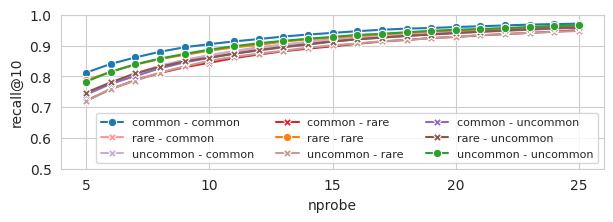

In [28]:
palette = sns.color_palette("tab20", 20) 

sns.set_style("whitegrid")
plt.figure(figsize=(7, 2))

marker_size = 6
seg = [4,25]
x_ticks = [5,10,15,20,25]
y_ticks = [0.5,0.6,0.7,0.8,0.9,1.0]

sns.lineplot(x=nprobe_values[seg[0]: seg[1]], y=recalls_ivf_common_common[seg[0]: seg[1]],     marker="o", markersize=marker_size, label='common - common', color=palette[0])
sns.lineplot(x=nprobe_values[seg[0]: seg[1]], y=recalls_ivf_rare_common[seg[0]: seg[1]],       marker="X", markersize=marker_size, label='rare - common', color=palette[7])
sns.lineplot(x=nprobe_values[seg[0]: seg[1]], y=recalls_ivf_uncommon_common[seg[0]: seg[1]],   marker="X", markersize=marker_size, label='uncommon - common', color=palette[9])
sns.lineplot(x=nprobe_values[seg[0]: seg[1]], y=recalls_ivf_common_rare[seg[0]: seg[1]],       marker="X", markersize=marker_size, label='common - rare', color=palette[6])
sns.lineplot(x=nprobe_values[seg[0]: seg[1]], y=recalls_ivf_rare_rare[seg[0]: seg[1]],         marker="o", markersize=marker_size, label='rare - rare', color=palette[2])
sns.lineplot(x=nprobe_values[seg[0]: seg[1]], y=recalls_ivf_uncommon_rare[seg[0]: seg[1]],     marker="X", markersize=marker_size, label='uncommon - rare', color=palette[11])
sns.lineplot(x=nprobe_values[seg[0]: seg[1]], y=recalls_ivf_common_uncommon[seg[0]: seg[1]],   marker="X", markersize=marker_size, label='common - uncommon', color=palette[8])
sns.lineplot(x=nprobe_values[seg[0]: seg[1]], y=recalls_ivf_rare_uncommon[seg[0]: seg[1]],     marker="X", markersize=marker_size, label='rare - uncommon', color=palette[10])
sns.lineplot(x=nprobe_values[seg[0]: seg[1]], y=recalls_ivf_uncommon_uncommon[seg[0]: seg[1]], marker="o", markersize=marker_size, label='uncommon - uncommon', color=palette[4])

plt.xticks(x_ticks)
plt.yticks(y_ticks)

# plt.title('Number of clusters probed by IVFFlat')
plt.xlabel('nprobe')
plt.ylabel(f"recall@{k}")

plt.legend(ncols=3, loc='lower right', fontsize=8)
plt.show()

In [29]:
recalls_hnsw_common_common = hnswflat_efsearch_recall(vectors_base_common, vectors_base_common, query_size=query_size, k=k, m=m, efConstruction=efConstruction, efSearch_values=efSearch_values)
recalls_hnsw_common_rare = hnswflat_efsearch_recall(vectors_base_common, vectors_base_rare, query_size=query_size, k=k, m=m, efConstruction=efConstruction, efSearch_values=efSearch_values)
recalls_hnsw_common_uncommon = hnswflat_efsearch_recall(vectors_base_common, vectors_base_uncommon, query_size=query_size, k=k, m=m, efConstruction=efConstruction, efSearch_values=efSearch_values)
recalls_hnsw_rare_common = hnswflat_efsearch_recall(vectors_base_rare, vectors_base_common, query_size=query_size, k=k, m=m, efConstruction=efConstruction, efSearch_values=efSearch_values)
recalls_hnsw_rare_rare = hnswflat_efsearch_recall(vectors_base_rare, vectors_base_rare, query_size=query_size, k=k, m=m, efConstruction=efConstruction, efSearch_values=efSearch_values)
recalls_hnsw_rare_uncommon = hnswflat_efsearch_recall(vectors_base_rare, vectors_base_uncommon, query_size=query_size, k=k, m=m, efConstruction=efConstruction, efSearch_values=efSearch_values)
recalls_hnsw_uncommon_common = hnswflat_efsearch_recall(vectors_base_uncommon, vectors_base_common, query_size=query_size, k=k, m=m, efConstruction=efConstruction, efSearch_values=efSearch_values)
recalls_hnsw_uncommon_rare = hnswflat_efsearch_recall(vectors_base_uncommon, vectors_base_rare, query_size=query_size, k=k, m=m, efConstruction=efConstruction, efSearch_values=efSearch_values)
recalls_hnsw_uncommon_uncommon = hnswflat_efsearch_recall(vectors_base_uncommon, vectors_base_uncommon, query_size=query_size, k=k, m=m, efConstruction=efConstruction, efSearch_values=efSearch_values)

groundtruth
build hnsw


100%|██████████| 100/100 [00:11<00:00,  8.67it/s]


groundtruth
build hnsw


100%|██████████| 100/100 [00:12<00:00,  8.23it/s]


groundtruth
build hnsw


100%|██████████| 100/100 [00:11<00:00,  8.36it/s]


groundtruth
build hnsw


100%|██████████| 100/100 [00:17<00:00,  5.57it/s]


groundtruth
build hnsw


100%|██████████| 100/100 [00:17<00:00,  5.63it/s]


groundtruth
build hnsw


100%|██████████| 100/100 [00:18<00:00,  5.54it/s]


groundtruth
build hnsw


100%|██████████| 100/100 [00:14<00:00,  6.97it/s]


groundtruth
build hnsw


100%|██████████| 100/100 [00:14<00:00,  6.84it/s]


groundtruth
build hnsw


100%|██████████| 100/100 [00:14<00:00,  7.01it/s]


In [30]:
# 列表和它们的名称
lists = {
    "recalls_hnsw_common_common": recalls_hnsw_common_common,
    "recalls_hnsw_common_rare": recalls_hnsw_common_rare,
    "recalls_hnsw_common_uncommon": recalls_hnsw_common_uncommon,
    "recalls_hnsw_rare_common": recalls_hnsw_rare_common,
    "recalls_hnsw_rare_rare": recalls_hnsw_rare_rare,
    "recalls_hnsw_rare_uncommon": recalls_hnsw_rare_uncommon,
    "recalls_hnsw_uncommon_common": recalls_hnsw_uncommon_common,
    "recalls_hnsw_uncommon_rare": recalls_hnsw_uncommon_rare,
    "recalls_hnsw_uncommon_uncommon": recalls_hnsw_uncommon_uncommon
}

write_recalls("dataset_analysis/mtg_hnsw.txt", lists)

In [31]:
read_recalls("dataset_analysis/mtg_hnsw.txt")

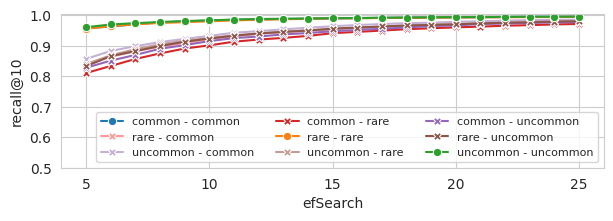

In [32]:
palette = sns.color_palette("tab20", 20) 

sns.set_style("whitegrid")
plt.figure(figsize=(7, 2))

marker_size = 6
seg = [4,25]
x_ticks = [5,10,15,20,25]
y_ticks = [0.5,0.6,0.7,0.8,0.9,1.0]

sns.lineplot(x=nprobe_values[seg[0]: seg[1]], y=recalls_hnsw_common_common[seg[0]: seg[1]],     marker="o", markersize=marker_size, label='common - common', color=palette[0])
sns.lineplot(x=nprobe_values[seg[0]: seg[1]], y=recalls_hnsw_rare_common[seg[0]: seg[1]],       marker="X", markersize=marker_size, label='rare - common', color=palette[7])
sns.lineplot(x=nprobe_values[seg[0]: seg[1]], y=recalls_hnsw_uncommon_common[seg[0]: seg[1]],   marker="X", markersize=marker_size, label='uncommon - common', color=palette[9])
sns.lineplot(x=nprobe_values[seg[0]: seg[1]], y=recalls_hnsw_common_rare[seg[0]: seg[1]],       marker="X", markersize=marker_size, label='common - rare', color=palette[6])
sns.lineplot(x=nprobe_values[seg[0]: seg[1]], y=recalls_hnsw_rare_rare[seg[0]: seg[1]],         marker="o", markersize=marker_size, label='rare - rare', color=palette[2])
sns.lineplot(x=nprobe_values[seg[0]: seg[1]], y=recalls_hnsw_uncommon_rare[seg[0]: seg[1]],     marker="X", markersize=marker_size, label='uncommon - rare', color=palette[11])
sns.lineplot(x=nprobe_values[seg[0]: seg[1]], y=recalls_hnsw_common_uncommon[seg[0]: seg[1]],   marker="X", markersize=marker_size, label='common - uncommon', color=palette[8])
sns.lineplot(x=nprobe_values[seg[0]: seg[1]], y=recalls_hnsw_rare_uncommon[seg[0]: seg[1]],     marker="X", markersize=marker_size, label='rare - uncommon', color=palette[10])
sns.lineplot(x=nprobe_values[seg[0]: seg[1]], y=recalls_hnsw_uncommon_uncommon[seg[0]: seg[1]], marker="o", markersize=marker_size, label='uncommon - uncommon', color=palette[4])

plt.xticks(x_ticks)
plt.yticks(y_ticks)

plt.xlabel('efSearch')
plt.ylabel(f"recall@{k}")

plt.legend(ncols=3, loc='lower right', fontsize=8)
plt.show()

Processing: (2, 2): 100%|██████████| 9/9 [00:27<00:00,  3.04s/it]


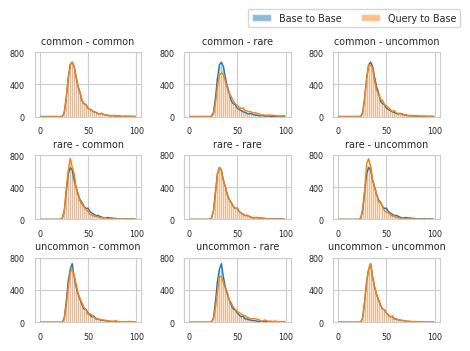

In [33]:
mahalanobis_distances_histograms(
    vectors_base_cru, rarity_cru, 
    sample_size_1=5000, sample_size_2=5000, x_lim=100, x_ticks=[0,50,100], y_ticks=[0,400,800],
    hspace=0.6, wspace=0.4, bbox_to_anchor=(1,1.1), figsize=(4.5,3), show_word=False                              
)

Processing: (2, 2): 100%|██████████| 6/6 [05:29<00:00, 54.98s/it]


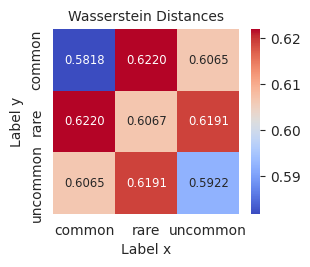

In [34]:
wasserstein_distances_heatmap(vectors_base_cru, rarity_cru, sample_size_1=5000, sample_size_2=5000, precision=".4f")